In [271]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

SynDECA - A Tool to Generate Synthetic Datasets for Evaluation of Cluster Algorithm
- 摘要：  
    聚类算法有很多，而需要数据集来和评估之。本算法自动生成[有生命力的]数据集，评估聚类算法的准确性、抗噪性。  
- 问题描述：  
    给定-数据集大小n，维度d，范围[0 , m]，聚类个数c，噪声比例η  
    输出-随机产生的数据集。
- 步骤：  
    1.确定聚类中心，包括大小边缘  
    2.聚类和噪声大小估计  
    3.填聚类  
    4.撒噪声  

In [205]:
# Input ( as global para 
n = 5000 # total number
d = 3 # dimension
m = 1000 # max value in each dimension
c = 5 # cluster number 
yita = 0.05 # noise-points/cluster-points

# steps
一些内部变量：

$\epsilon$ - 聚类间的最小距离比。任意两个聚类之间的距离不能小于$(1+\epsilon)r$，where r is the radius of a cluster   
$r_{max} , r_{min} $ - 聚类最大/最小半径  
P.S. 噪点数量$\in (0, \frac{1}{1+c}*n] $ (意思是不能大于一个聚类的比例

In [206]:
# Input (cont.
epsilon = 0.5
r_min = 50
r_max = 200

## step 1 定聚类位置及半径
意思大概是，先随机产生中心和半径，放着。冲突就减小，直到没冲突了就安排。
### gapIsEnough

In [207]:
def gapIsEnough(r_i, miu_i, r_j, miu_j):
    def distance(p1,p2):# p1 p2 are 2 points, array type.
        return max(abs(p1-p2))
    d = distance(miu_i,miu_j)
    return  (d > r_i + r_j) and (d > r_i *(1 + epsilon)) and (d > r_j *(1 + epsilon)) # NOT SURE

### ClusterPlacement
（事实上复杂度很高）

In [208]:
def reduce(r_i):
    return r_i - 0.1*r_min # NOT SURE 。太快直接低于r_min 会重来，太慢收敛慢
def ClusterPlacement(r_k, miu_k): # miu_k , r_k are miu and r set, respectively
    r_i = np.random.random() * (r_max - r_min) + r_min # in [r_min,r_max]
    miu_i = np.random.random(d) * (m - 2 * r_i) + r_i # d-dimension array
    if len(r_k)==0:
        return r_i,miu_i
    else:
        for miu_j, r_j in [(miu_k[i], r_k[i]) for i in range(len(r_k))]: 
            while not gapIsEnough(r_i, miu_i, r_j, miu_j) :
                r_i = reduce(r_i)
                if r_i < r_min:
                    return ClusterPlacement(r_k, miu_k)
        return r_i , miu_i 

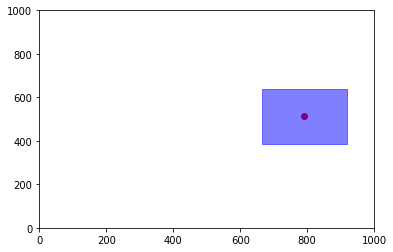

In [209]:
# TEST 产生一个聚类中心和半径
def TEST_oneClusterPlacement():
    TEST_r_i ,TEST_miu_i = ClusterPlacement(np.array([]),np.array([]))
    fig=plt.figure()
    ax = fig.add_subplot(111, aspect='auto')
    plt.scatter(TEST_miu_i[0],TEST_miu_i[1],c='r')
    plt.axis([0,m,0,m])
    ax.add_patch(mpatches.Rectangle(TEST_miu_i-TEST_r_i, TEST_r_i*2,TEST_r_i*2, color = 'b', alpha=0.5))
TEST_ClusterPlacement()

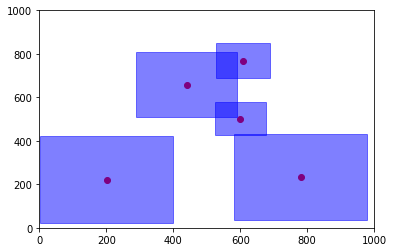

In [210]:
# TEST 产生所有聚类中心及半径
def TEST_allClusterPlacement():
    TEST_r = np.array([])
    TEST_miu = np.array([])
    for i in range(c):
        TEST_r_new , TEST_miu_new = ClusterPlacement(r_k = TEST_r, miu_k = TEST_miu)
        TEST_r = np.append(TEST_r , TEST_r_new)
        TEST_miu = np.append(TEST_miu , TEST_miu_new)
        TEST_miu = TEST_miu.reshape(int(len(TEST_miu)/d),d)

    # 画图
    fig=plt.figure()
    ax = fig.add_subplot(111, aspect='auto')
    plt.scatter([i[0] for i in TEST_miu],[i[1] for i in TEST_miu],c='r')
    plt.axis([0,m,0,m])
    for i in range(c):
        ax.add_patch(mpatches.Rectangle(TEST_miu[i]-TEST_r[i], TEST_r[i]*2,TEST_r[i]*2, color = 'b', alpha=0.5))    
TEST_allClusterPlacement()

## step 2 撒点
n Number  
miu_j Center  
r_j Shape  
Xj   
shape = [-1,0,1,2] # Irregular, Circle, Square, Ellipse, Rectangle,  

### generate_point

In [211]:
def generate_point(r_i,miu_i):
    return ( 2*np.random.random(d) -1 )* r_i + miu_i 

In [212]:
# TEST
generate_point(*ClusterPlacement(np.array([]),np.array([])))

array([401.94512676, 836.82229523, 104.1108789 ])

### sprinkle_point

In [213]:
def sprinkle_point(p, eps, min_pts): # sprinkle surrounding the point p
    # reverse DB-SCAN
    points = np.array([])
    for i in range(min_pts):
        # NOT SURE: "around" here means "within the bounding box". 
        points = np.append(points,generate_point(miu_i=p,r_i=eps)) # note that np.array + array means matrix plus
    return points.reshape(min_pts,d)

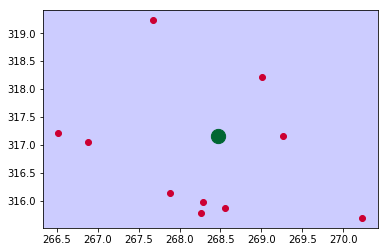

In [214]:
# TEST 在一个点周围撒随机点
def TEST_sprinkle_point():
    TEST_one_r,TEST_one_point = ClusterPlacement(np.array([]),np.array([]))
    TEST_sprinlke_point = sprinkle_point(p=TEST_one_point, eps=0.02*TEST_one_r, min_pts=10)

    # 画图
    fig=plt.figure()
    ax = fig.add_subplot(111, aspect='auto')
    plt.scatter(*TEST_one_point,c='g')
    plt.scatter([i[0] for i in TEST_sprinlke_point],[i[1] for i in TEST_sprinlke_point],c='r')
    ax.add_patch(mpatches.Rectangle(TEST_one_point-TEST_one_r, TEST_one_r*2,TEST_one_r*2, color = 'b', alpha=0.2))
TEST_sprinkle_point()

### get_a_point

In [215]:
def get_a_point( eps,p, eps_):
    # randomly generate a point with distance of q_ from p, where eps < q_ < eps + eps_ 
    while True:
        p_ = generate_point(miu_i=p, r_i=eps+eps_)
        if np.linalg.norm(p_-p,2) > eps and np.linalg.norm(p_-p,2) < eps+eps_ :
            break
    return p_

In [216]:
# TEST
get_a_point(*ClusterPlacement(np.array([]),np.array([])), eps_=0.002)

array([604.32878242, 286.36913263, 548.71610466])

### is_within_cluster_area

In [233]:
def is_within_cluster_area(shape, point, miu_i, r_i, rad_i):
    if shape == -1: # irregular
        return False # NOT SURE 随便撒
    if shape == 0: # Rectangle. Rad_i = half length in every demension 
        return (abs(point - miu_i)/rad_i < 1 ).all() 
    if shape == 1: # Ellipse. Rad_i = half length in every demension
        return sum((point-miu_i)**2/rad_i**2)<1

### ClusterPointsGeneration

In [218]:
def ClusterPointsGeneration(n_j, r_j, miu_j, shape, rad_i, alpha): # generate n_j points surrounding the cluster center miu_j
    points=np.array([])
    if shape == -1 : #irregular
        eps=0.02*r_j
        eps_=0.05*r_j
        p = miu_j # NOT SURE 直接用聚类中心做初始点
        min_pts = int(alpha * n_j)
#         points = sprinkle_point(p=p, eps=eps, min_pts=min_pts)
        while len(points) < n_j:
            p_ = get_a_point(p=p,eps=eps,eps_=eps_)
#             points = np.vstack([points, sprinkle_point(p=p_, eps=eps_, min_pts=min_pts)])
            points = np.append(points, sprinkle_point(p=p_, eps=eps_, min_pts=min_pts))
            points = points.reshape(int(len(points)/d), d)
            p=p_
            eps = eps_ #NOT SURE
    else:
        while len(points) < n_j:
            p = generate_point(r_i=r_j, miu_i=miu_j )
            if is_within_cluster_area(shape=shape, point=p, miu_i=miu_j, r_i=r_j, rad_i=rad_i):
                if len(points)==0:
                    points = p
                else:
                    points = np.vstack([p,points])
    return points

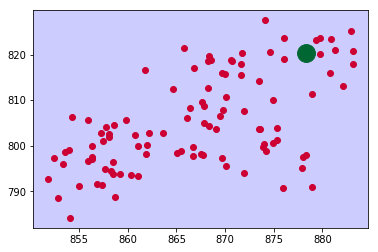

In [219]:
# TEST 为一个聚类撒点
def TEST_ClusterPointsGeneration():
    TEST_cluster_r,TEST_cluster_center = ClusterPlacement(np.array([]),np.array([]))
    points = ClusterPointsGeneration(
        n_j=100, 
        r_j=TEST_cluster_r, miu_j=TEST_cluster_center,
        shape=-1,
        rad_i=[150,260],
        alpha=0.03
    )
    # 画图
    fig=plt.figure()
    ax = fig.add_subplot(111, aspect='auto')
#     plt.axis([0,m,0,m])
    plt.scatter(*TEST_cluster_center,c='g')
    plt.scatter([i[0] for i in points],[i[1] for i in points],c='r')
    ax.add_patch(mpatches.Rectangle(TEST_cluster_center - TEST_cluster_r, TEST_cluster_r*2,TEST_cluster_r*2, color = 'b', alpha=0.2))
TEST_ClusterPointsGeneration()

## step 3
不在任何一个聚类内

给定：
yita ，噪点比  
n 总数  
(miu_k, f_k) miu_k - 聚类中心。f_k 包括半径r_k, shape_k, rad_ik, eps_k 
m 范围  


In [220]:
def make_a_noise_point(miu_k, r_k, shape_k, radi_k, eps_k, m):
    num = len(miu_k) #聚类个数
    point = np.random.random(d) * m # 在整个区域内 make a random point 
    # 先判断是否在任何矩形半径之外
    for i in range(num):
        if np.array([ abs(point - miu_k[i]) > r_k[i] ]).all(): # 不在任何一个矩形半径内
            continue
        if i == num-1: # 全部通过
            return point            
    # check if out of cluster
    for i in range(num): 
        if is_within_cluster_area(shape=shape_k[i] , miu_i=miu_k[i] , point=point , r_i=r_k[i],rad_i=radi_k[i]):
            return make_a_noise_point(miu_k, r_k, shape_k, radi_k, eps_k, m) # 一旦在某个内，重新找
    return point

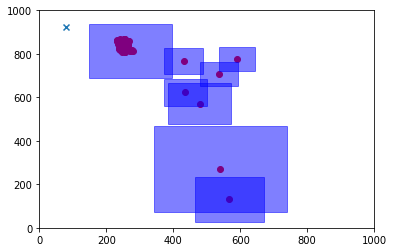

In [228]:
# TEST 产生一个不在任意聚类内的噪点
def TEST_make_a_noise_point():
    # 产生所有的聚类，以及其属性，包括shape rad eps
    TEST_r = np.array([])
    TEST_miu = np.array([])
    TEST_shape = np.array([])
    TEST_rad = np.array([])
    TEST_eps = np.array([])
    for i in range(c):
        TEST_r_new , TEST_miu_new = ClusterPlacement(r_k = TEST_r, miu_k = TEST_miu)
        TEST_r = np.append(TEST_r , TEST_r_new)
        TEST_miu = np.append(TEST_miu , TEST_miu_new)
        TEST_miu = TEST_miu.reshape(int(len(TEST_miu)/d),d)
        TEST_shape = np.append(TEST_shape, np.random.randint(-1,2))
        if len(TEST_rad)==1:
            TEST_rad = np.random.random(d) * TEST_r_new
        else: TEST_rad = np.append(TEST_rad, np.random.random(d) * TEST_r_new)
        TEST_eps = 0.01 * TEST_r_new
        
    # 为其中一个聚类产撒点
    TEST_clusterpoints = ClusterPointsGeneration(
        n_j=100, 
        r_j=TEST_r[0], miu_j=TEST_miu[0],
        shape=TEST_shape[0],
        rad_i=TEST_rad[0],
        alpha=0.03
    )

    # 加噪点——不在任何一个聚类内
    noisepoint = make_a_noise_point(miu_k=TEST_miu, r_k=TEST_r, eps_k=TEST_eps, m=m, radi_k=TEST_rad, shape_k=TEST_shape)

    # 画图
    fig=plt.figure()
    ax = fig.add_subplot(111, aspect='auto')
    plt.axis([0,m,0,m])

    plt.scatter([i[0] for i in TEST_miu],[i[1] for i in TEST_miu],c='r')
    plt.scatter([i[0] for i in TEST_clusterpoints],[i[1] for i in TEST_clusterpoints],c='r')
    plt.scatter(noisepoint[0], noisepoint[1] ,marker='x')
    for i in range(c):
        ax.add_patch(mpatches.Rectangle(TEST_miu[i]-TEST_r[i], TEST_r[i]*2,TEST_r[i]*2, color = 'b', alpha=0.5))    
TEST_make_a_noise_point()

In [222]:
def NoisePointsGeneration(yita, n, miu_k, r_k, shape_k, radi_k, eps_k, m):
    noise_points = np.array([])
    while len(noise_points)< n*yita:
        new_noise_point = make_a_noise_point(miu_k=miu_k, r_k=r_k, shape_k=shape_k, radi_k=radi_k, eps_k=eps_k, m=m)
        noise_points = np.append(noise_points, new_noise_point)
    noise_points = noise_points.reshape(int(len(noise_points)/d),d)
#     print(noise_points)
    return noise_points

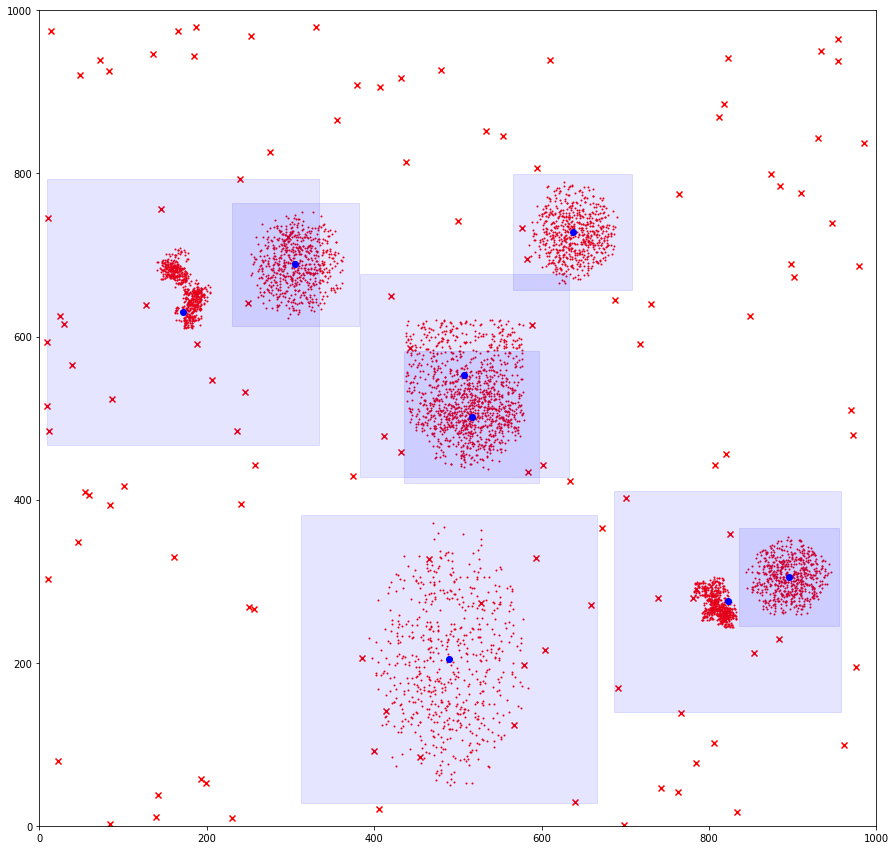

In [304]:
# TEST ALL
# 预设参数
n = 5000 # total number
d = 4 # dimension
m = 1000 # max value in each dimension
c = 8 # cluster number 
yita = 0.1 # noise-points/cluster-points
epsilon = 0.5
r_min = 50
r_max = 200
def ALL():
    # STEP-1 产生所有的聚类，以及其属性，包括shape rad eps    
    TEST_r = np.array([])
    TEST_miu = np.array([])
    TEST_n_j = np.array([int(n/c) for i in range(c)]) # 聚类中点的个数。暂定均分 
    TEST_shape = np.array([])
    TEST_rad = np.array([])
    TEST_eps = np.array([])
    for i in range(c):
        TEST_r_new , TEST_miu_new = ClusterPlacement(r_k = TEST_r, miu_k = TEST_miu)
        TEST_r = np.append(TEST_r , TEST_r_new)
        TEST_miu = np.append(TEST_miu , TEST_miu_new)
        TEST_miu = TEST_miu.reshape(int(len(TEST_miu)/d),d)
        TEST_shape = np.append(TEST_shape, np.random.randint(-1,2))
        TEST_rad = np.append(TEST_rad, np.random.random(d)*(TEST_r_new - r_min) + r_min)
        TEST_rad = TEST_rad.reshape(int(len(TEST_rad)/d),d)
        TEST_eps = np.append(0.01 * TEST_r_new,TEST_eps)
    # STEP-2 为每个聚类撒点
    TEST_clusterpoints = np.array([])
    TEST_clusterpoints_label = np.array([])
    for i in range(c):
        TEST_newpointsForcluster = ClusterPointsGeneration(
            n_j=TEST_n_j[i], # NOT SURE 暂定均分 
            r_j=TEST_r[i], miu_j=TEST_miu[i],
            shape=TEST_shape[i],
            rad_i=TEST_rad[i],
            alpha=0.03
        )
        TEST_clusterpoints = np.append(TEST_clusterpoints, TEST_newpointsForcluster)
        TEST_clusterpoints_label = np.append(TEST_clusterpoints_label, np.array([i for k in range(len(TEST_newpointsForcluster))])  )
    TEST_clusterpoints = TEST_clusterpoints.reshape(int(len(TEST_clusterpoints)/d),d)
    assert( len(TEST_clusterpoints_label) == len(TEST_clusterpoints))
    # STEP-3 加噪点
    noisepoints = NoisePointsGeneration(n=n,yita=yita ,miu_k=TEST_miu, r_k=TEST_r, eps_k=TEST_eps, m=m, radi_k=TEST_rad, shape_k=TEST_shape)
    
    # 画图
    fig=plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, aspect='auto')
    plt.axis([0,m,0,m])

    plt.scatter([i[0] for i in TEST_clusterpoints],[i[1] for i in TEST_clusterpoints],c='r',s=1)
    plt.scatter([i[0] for i in TEST_miu],[i[1] for i in TEST_miu],c='b',)
    plt.scatter([i[0] for i in noisepoints],[i[1] for i in noisepoints],c='r',marker='x')
    for i in range(c):
        ax.add_patch(mpatches.Rectangle(TEST_miu[i]-TEST_r[i], TEST_r[i]*2,TEST_r[i]*2, color = 'b', alpha=0.1))    
    
    
    TEST_allpoints = np.append(TEST_clusterpoints , noisepoints)
    TEST_allpoints = TEST_allpoints.reshape(int(len(TEST_allpoints)/d),d)
    TEST_label = np.append(TEST_clusterpoints_label , [-1 for x in range(len(noisepoints))])
    return TEST_r , TEST_miu ,TEST_shape , TEST_rad , TEST_eps ,TEST_allpoints,TEST_label
TEST_OUTPUT = ALL()

In [310]:
#  r , center ,shape , rad , eps ,allpoints_data  ,label
TEST_OUTPUT[0] # Radius of each cluster
TEST_OUTPUT[1] # Cluster center
TEST_OUTPUT[2] # Cluster shape. -1: iiregular, 0: rectangle, 1: ellipse
TEST_OUTPUT[3] # Shape radius under each dimension. 
TEST_OUTPUT[4] # Eps for irregular-shaped clusters
TEST_OUTPUT[5] # ALL points
TEST_OUTPUT[6] # Label 

OUTPUTdf = pd.DataFrame(np.append(TEST_OUTPUT[5] ,np.vstack(TEST_OUTPUT[6]),axis=1))
OUTPUTdf

,0,1,2,3,4
0,179.601156,624.386098,766.646215,744.653557,0.0
1,176.239060,626.107329,761.625541,749.127460,0.0
2,174.603732,624.544170,772.365443,753.945590,0.0
3,180.919600,628.366540,763.321337,749.648152,0.0
4,186.733214,626.002000,761.385792,748.607113,0.0
5,180.609043,626.856342,763.621142,742.400053,0.0
6,172.961688,622.704603,772.312179,749.977613,0.0
7,183.789615,620.439467,763.583986,744.715752,0.0
8,176.473804,620.740566,764.195229,754.087446,0.0
9,172.125510,632.914335,771.051322,752.548915,0.0
